This is a slightly cleaned up version of the slides for a presentation I gave at the SLCPy meetup a while ago. I intended to write something with nice prose and turn it into something that can stand on its own without the verbal commentary that went along with it, but that isn't going to happen so here are the raw slides. 

<!-- TEASER_END -->

There is a video of the event but unfortunately because of technical troubles it is audio only. Despite the title of the video the meetup happened in March. The first hour of the video is just people talking eating pizza and random pieces of business for the python group. Skip to 1 hour and 18 minutes in to the video to hear the actual presentation.

https://www.youtube.com/watch?v=DOt-g2y3t6s

In [1]:
from IPython.display import Image

# Learning TensorFlow by Designing 3D Printables

## SLC Python Meetup March 1, 2017

<img src=../images/geb_mesh.png width=500 height=500>

# What is TensorFlow

* TensorFlow is Google's open source Python library for machine learning.

* TensorFlow is a way to take advantage of GPU's and multiple core CPU's for heavy number crunching.

* TensorFlow is a solution to remove the overhead of returning to the python interpreter in between each step of a heavy numerical code.

# What is Machine Learning?

My Definition: Machine learning is declarative programming taken to its logical extreme.

Declarative Programming: Tell a computer what we want but not exactly how to do it.

Supervised Machine Learning: Tell a computer what we want (a metric) and let it figure out how to do it (best parameters for our function).





# How To Learn TensorFlow

Look at some tutorials and get one working.

* Getting Started Including MNIST hello world. 
https://www.tensorflow.org/get_started/get_started

* Mandelbrot Set Computation
https://www.tensorflow.org/tutorials/mandelbrot

* Transfer Learning by Retraining Last Layer of Inception
https://www.tensorflow.org/tutorials/image_retraining




Then pick your own project and do it!

I vowed to use the 3D printing capabilities on campus at least once before I leave the U. 
Why not kill two birds with one stone? Learn tesor flow by making it learn to 3D print!

# But 3D Printing is Not a Machine Learning Problem! Right?



* If we can tell a computer how to represent a 3D object as a big pile of numbers... (parameters)

* and we can tell a computer how to compute a numerical "desirability" of those objects... (a metric)


# 3D Printing Can Be A Machine Learning Problem!

* If we can tell a computer how to represent an object we would like as a big pile of numbers... 
* and we can tell a computer how to compute a numerical "desirability" of those objects...

Then we can use the tools of machine learning to "learn" a representation for our object!


# TensorFlow Overview


*  tf.Operation  --> nodes in an execution graph

* tf.Tensor      -->  outputs of operations

* tf.Variable    --> free parameters

* tf.placeholder --> data and/or hyper parameters

* tf.Session  --> manages state of Variables and executes operations on Tensors



# Analogy To Mathematical Function Optimization

In the familar mathematical context of model fitting we might write.

$$
{\large y = f(x | \theta)}
$$

Where we wish to tweak the parameters $\theta$ to minimize some risk $R$ given observations $x_{obs}$ and $y_{obs}$
The correspondence in tensor flow is fairly one to one

* y, x <--> tf.placeholder
* f, R<--> tf.Operation
* $\theta$ <--> tf.Variable


# The Hammer: Mini-Batch Stochastic Gradient Descent

* calculate the derivative of our metric with respect to our current parameters for some small batch of data.


$$
{\large \nabla_{\theta} R = \frac{\partial R(y_{batch}, f(x_{batch}|\theta_t))}{\partial \theta}} 
$$


* Then move "down the slope" by some small step size (the learning rate).


$$
{\large \theta_{t+1} = \theta_t - \epsilon \nabla_{theta}R}
$$

# Okay But Scipy Can Do Gradient Descent Too. 

## What Makes TensorFlow So Great?



* Easy GPU/Multi-Core Number Crunching.

* Auto-differentiation


* Auto-differentiation


* Auto-differentiation


When you have millions of parameters and function evaluations can take seconds estimating $\partial f(x | \theta)/ \partial \theta_i$ for all million parameters using a finite differences method is not feasible.

You need an analytic form for the derivative.

TensorFlow is not the only thing that does this (e.g. STAN, and Theano) just the newest slickest thing that does it.


# Baby Steps: Fit A Linear Model

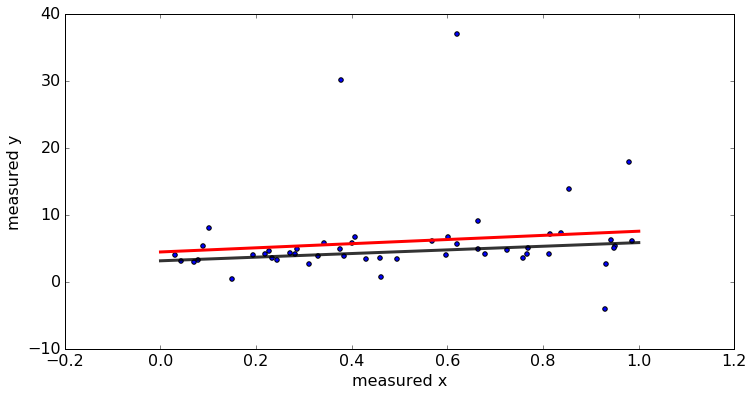

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({"figure.figsize":(12,6), "font.size":16})

np.random.seed(4321)

true_slope = np.e
true_offset = np.pi

#make some noisy data
npts = 50
x = np.random.uniform(0, 1, npts)
noise = np.random.standard_cauchy(size=(npts,))
y_true = true_slope*x + true_offset
y = y_true + noise

plt.scatter(x, y)
xspan = np.linspace(0, 1, 100)
lsq_soln = np.linalg.lstsq(np.vander(x, 2), y)[0]
lsq_model = np.dot(np.vander(xspan, 2), lsq_soln)
plt.plot(xspan, xspan*true_slope + true_offset, c="k", lw=3, alpha=0.8, label="True")
plt.plot(xspan, lsq_model, c="r", lw=3, label="Least Squares")
plt.xlabel("measured x")
plt.ylabel("measured y")


In [2]:
import tensorflow as tf

#TensorFlow is still rapidly evolving so the version you are using really matters
print("TensorFlow version", tf.__version__)

TensorFlow version 0.12.1


# TensorFlow Model

In [3]:
slope = tf.Variable(0.0, dtype=tf.float32)
offset = tf.Variable(0.0, dtype=tf.float32)

batch_size = 15
x_placeholder = tf.placeholder(dtype=tf.float32, shape=(batch_size,))
y_placeholder = tf.placeholder(dtype=tf.float32, shape=(batch_size,))

f = slope*x_placeholder + offset

sq_sum = tf.reduce_sum((y_placeholder - f)**2)

# Training Operation



In [4]:
opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = opt.minimize(sq_sum)

# Learning

In [5]:
param_history = []
batch_history = []

with tf.Session() as sess: #context manager for the session
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    n_batch = 20
    iter_per_batch = 10
    for batch_idx in range(n_batch):
        #get a batch of data
        batch_idxs = np.random.random(npts).argsort()[:batch_size]
        x_batch = x[batch_idxs]
        y_batch = y[batch_idxs]
        batch_history.append(batch_idxs)
        for iter_idx in range(iter_per_batch):
            #train our model
            sess.run(train_op, feed_dict={x_placeholder:x_batch, y_placeholder:y_batch})
            param_history.append(sess.run([slope, offset]))


param_history = np.array(param_history)

# Training Path

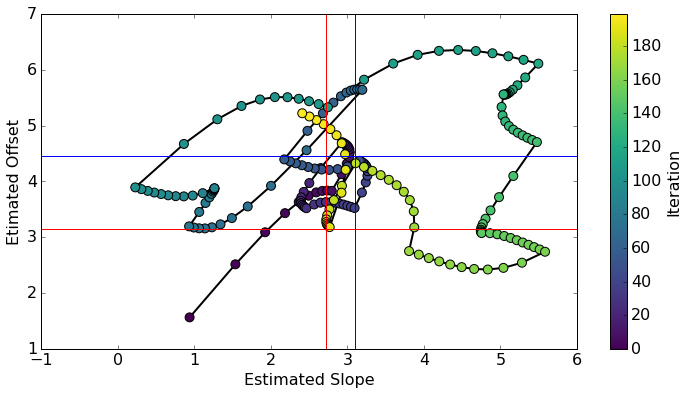

In [6]:
plt.plot(*param_history.T, zorder=0, c="k", lw=2)
plt.scatter(*param_history.T, c=np.arange(len(param_history)), s=80, cmap="viridis")
cbar = plt.colorbar()
cbar.set_label("Iteration")
plt.axvline(true_slope, c="r", label="True Values")
plt.axhline(true_offset, c="r", )

plt.axvline(lsq_soln[0], label="Least Squares")
plt.axhline(lsq_soln[1])

plt.xlabel("Estimated Slope")
plt.ylabel("Etimated Offset")

# Inspiration

![GEB cover](http://www.riverrundesign.com/wp-content/uploads/2013/09/Godel-Escher-Bach-edriverrun-05.jpg)

# General Strategy

* Represent objects in TensorFlow as point clouds
* Evaluate silhouettes of ojbects from each desired perspective.
* Compare the silhouette to a desired image.
* Calculate the sum of squared residuals of actual to desired silhouettes
* Use TensorFlow to optimize!
* Turn point cloud into mesh using the marching cubes algorithm.

# Why a Point Cloud? Wouldn't a 3D Tensor Be Better?

* More physically Intuitive
* (No) grid edges.
* Easier to effectively visualize
* More adaptive representation (sparse + easily refinable)
* Better illustrates the sort of troubles encountered in deep learning e.g.
  - Many local optima
  - Co-adaptation of parameters
  - Vanishing derivatives problem

* Also I just like point clouds.

# Calculating a Silhouette

In [7]:
def make_coordinate_sampler(x, lower_bound, upper_bound, npts):
    cx =(npts-1)*(x-lower_bound)/(upper_bound-lower_bound)
    nearest_xi_float = tf.floor(cx+0.5)
    nearest_xi_int = tf.to_int64(nearest_xi_float)
    delta = cx-nearest_xi_float
    
    return {
        "continuous_index":cx,
        "nearest_index":nearest_xi_int,
        "delta":delta,
    }


def make_silhouette(
        x, y,
        bounds,
        npts,
        silhouette_shape,
        delta_footprint,
        radial_basis_function,
    ):
        nx, ny = silhouette_shape
        min_x, max_x, min_y, max_y = bounds
        x_sampler = make_coordinate_sampler(x, min_x, max_x, nx)
        y_sampler = make_coordinate_sampler(y, min_y, max_y, ny)
        
        point_indexes = []
        x_indexes = []
        y_indexes = []
        footprint_indexes = []
        rbf_weights = []

        n_foot = len(delta_footprint)
        for footprint_idx in range(n_foot):
            dx, dy = delta_footprint[footprint_idx]
            x_idx = tf.clip_by_value(x_sampler["nearest_index"] - dx, 0, nx-1)
            y_idx = tf.clip_by_value(y_sampler["nearest_index"] - dy, 0, ny-1)
            r_delta = tf.sqrt((x_sampler["delta"] + dx)**2 + (y_sampler["delta"] + dy)**2)
            weight = radial_basis_function(r_delta)

            rbf_weights.append(weight)
            point_indexes.append(tf.range(0, npts, dtype=tf.int64))
            x_indexes.append(x_idx)
            y_indexes.append(y_idx)
            footprint_indexes.append(tf.constant(np.repeat(footprint_idx, npts)))

        #join the tensors together
        rbf_weights = tf.concat(concat_dim=0, values=rbf_weights)
        point_indexes = tf.concat(concat_dim=0, values=point_indexes)
        x_indexes = tf.concat(concat_dim=0, values=x_indexes)
        y_indexes = tf.concat(concat_dim=0, values=y_indexes)
        footprint_indexes = tf.concat(concat_dim=0, values=footprint_indexes)

        packed_indices = tf.stack([footprint_indexes, point_indexes, x_indexes, y_indexes], axis=1)
        sparse_shape = tf.constant(np.array([n_foot, npts, nx, ny]))
        sparse_opacity = tf.SparseTensor(packed_indices, values=rbf_weights, shape=sparse_shape)

        #sum over the footprint and point indexes to get a 2D tensor
        #dense_opacity = tf.sparse_reduce_sum(tf.sparse_reduce_sum_sparse(sparse_opacity, axis=0), axis=0)
        dense_opacity = tf.reduce_sum(tf.sparse_reduce_sum(sparse_opacity, axis=1), axis=0)
        
        silhouette = 1.0 - tf.exp(-0.5*tf.sqrt(dense_opacity))
        
        return{
            "silhouette":silhouette,
            "opacity":dense_opacity,
        }


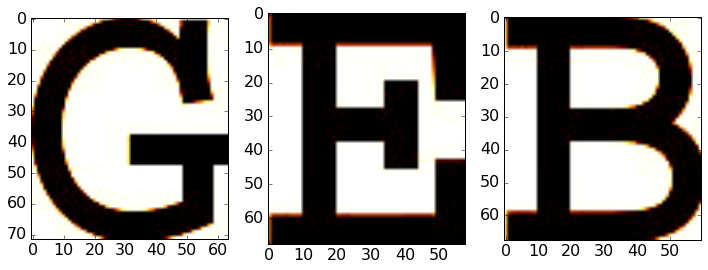

In [16]:
import scipy.misc

def load_im(fname):
    im = scipy.misc.imread(fname).astype(np.float32)
    im /= np.max(im)
    return im
    
G_im = load_im("G.jpg")
E_im = load_im("E.jpg")
B_im = load_im("B.jpg")

fig, ax = plt.subplots(1, 3)
for i, im in enumerate([G_im, E_im, B_im]):
    ax[i].imshow(im, cmap="afmhot_r")

In [36]:
npts_cloud = 30000
init_cloud_positions = np.random.uniform(low=-1, high=1, size=(npts_cloud, 3)).astype(np.float32)
cloud = tf.Variable(init_cloud_positions, name="cloud")

def make_delta_footprint(n_delt, max_radius=2):
    deltas = []
    for dx in range(-n_delt, n_delt+1):
        for dy in range(-n_delt, n_delt+1):
            if np.sqrt(dx**2 + dy**2) < max_radius:
                deltas.append((dx, dy))
    return deltas

deltas = make_delta_footprint(2)


g_silhouette = make_silhouette(
    x=cloud[:, 0], 
    y=cloud[:, 1],
    bounds=(-1, 1, -1, 1),
    npts=npts_cloud,
    silhouette_shape=G_im.shape,
    delta_footprint=deltas,
    radial_basis_function = lambda r: tf.exp(-r**2),
)

e_silhouette = make_silhouette(
    x=cloud[:, 0], 
    y=cloud[:, 2],
    bounds=(-1, 1, -1, 1),
    npts=npts_cloud,
    silhouette_shape=E_im.shape,
    delta_footprint=deltas,
    radial_basis_function = lambda r: tf.exp(-r**2),
)

b_silhouette = make_silhouette(
    x=cloud[:, 1], 
    y=cloud[:, 2],
    bounds=(-1, 1, -1, 1),
    npts=npts_cloud,
    silhouette_shape=B_im.shape,
    delta_footprint=deltas,
    radial_basis_function = lambda r: tf.exp(-r**2),
)


In [37]:
g_resids = g_silhouette["silhouette"] - G_im
e_resids = e_silhouette["silhouette"] - E_im
b_resids = b_silhouette["silhouette"] - B_im

gsum = tf.reduce_sum(g_resids**2)
esum = tf.reduce_sum(e_resids**2)
bsum = tf.reduce_sum(b_resids**2)
resid_sq_sum = gsum + esum + bsum

In [40]:
learning_rate = tf.placeholder(dtype=tf.float32)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = optimizer.minimize(resid_sq_sum, global_step=global_step)


In [41]:
#Lets use an interactive session since we are doing things interactively!

sess = tf.InteractiveSession()

initialize_op = tf.global_variables_initializer()
sess.run(initialize_op)



In [55]:
def plot_density():
    cloud_state = sess.run(cloud)
    fig, axes = plt.subplots(1, 3)
    cx, cy, cz = cloud_state.transpose()
    kwargs = dict(
        extent=(-1.1, 1.1, -1.1, 1.1),
        cmap="afmhot",
        vmin=0,
        vmax=20,
    )
    axes[0].hexbin(cy, cx, **kwargs)
    axes[1].hexbin(cz, cx, **kwargs)
    axes[2].hexbin(cz, cy, **kwargs)
    plt.show()

def run_training(train_op, n_iter, plot_frequency, rate):
    for i in range(n_iter):
        if i % plot_frequency == 0:
            plot_density()
        sess.run(train_op, feed_dict={learning_rate:rate})


# First Few Iterations

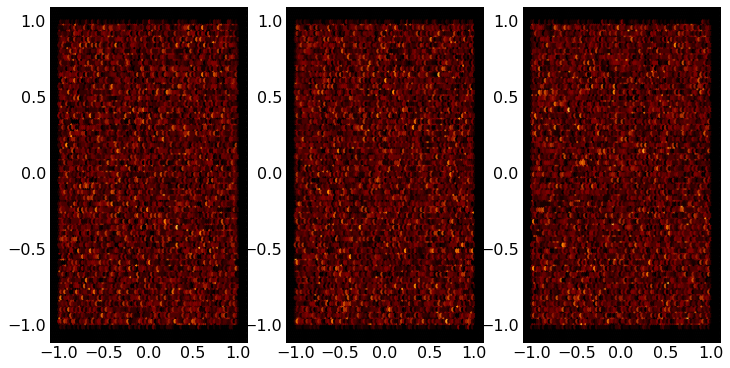

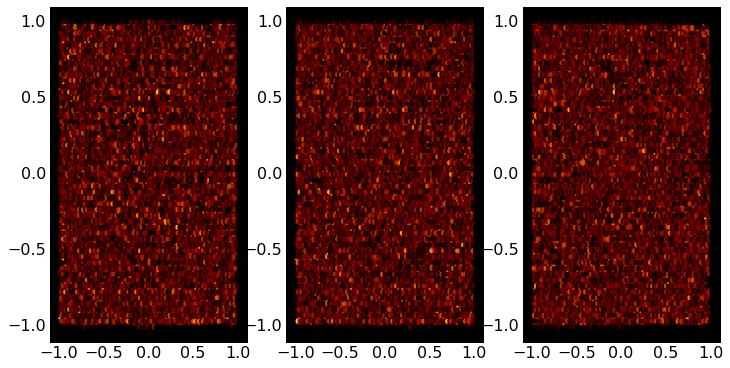

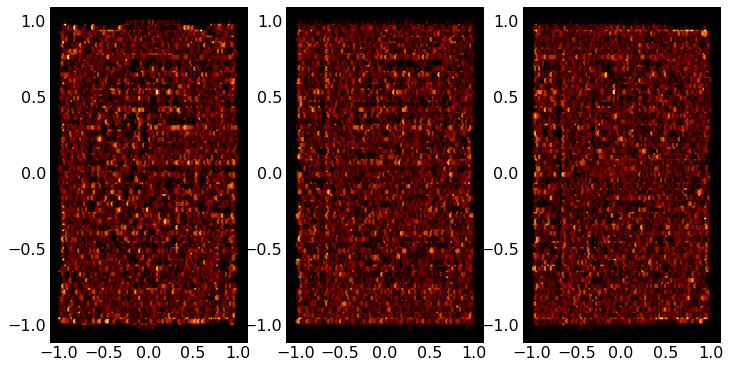

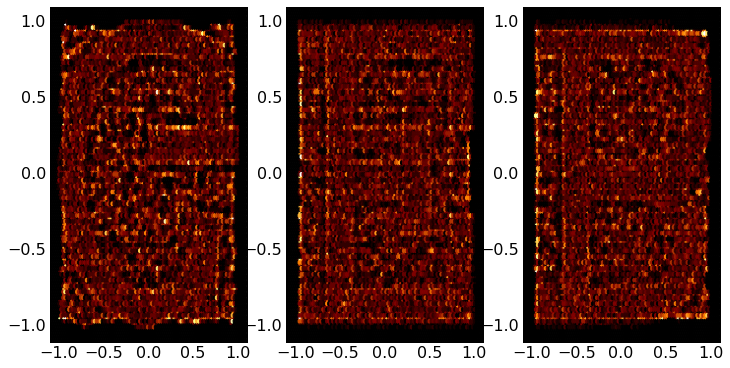

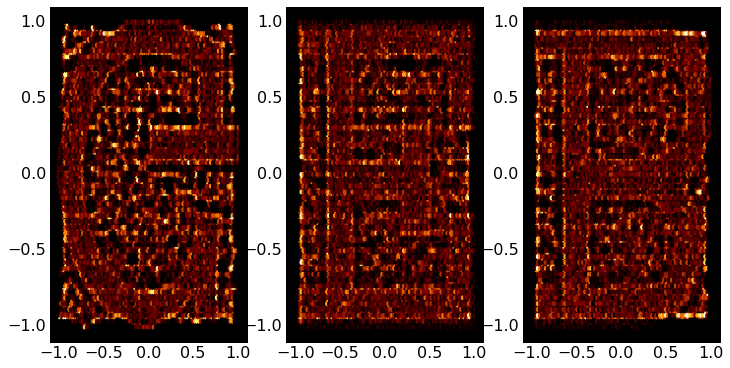

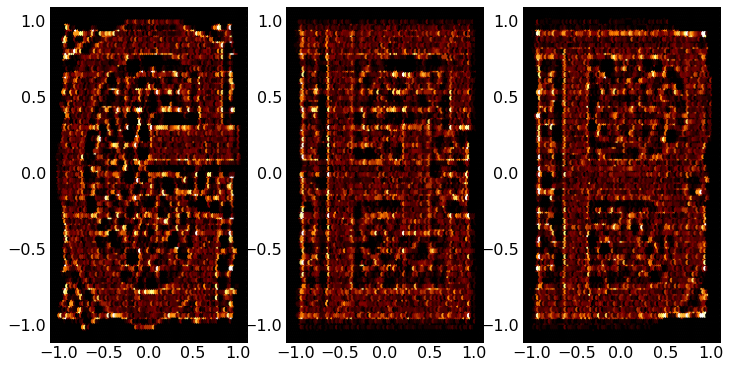

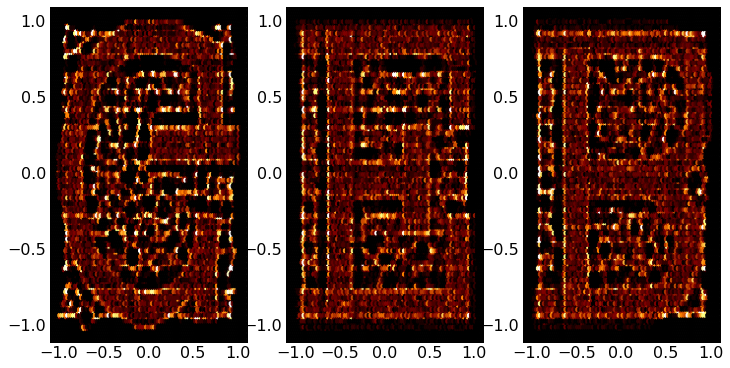

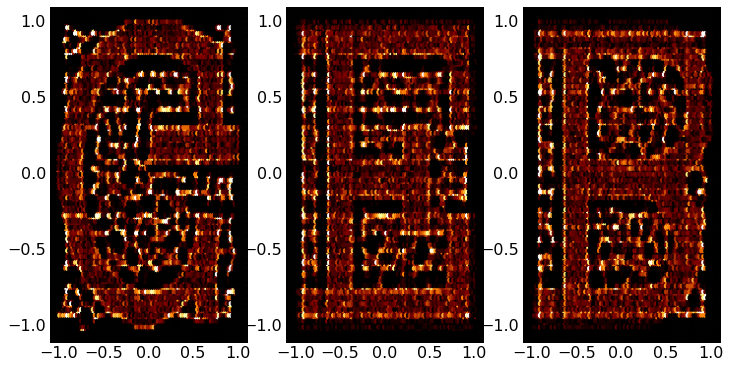

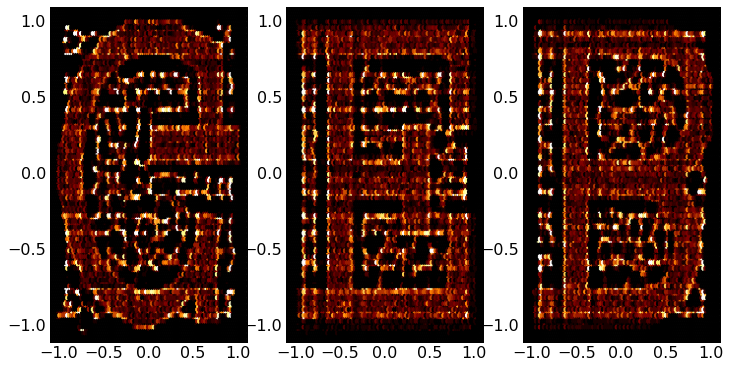

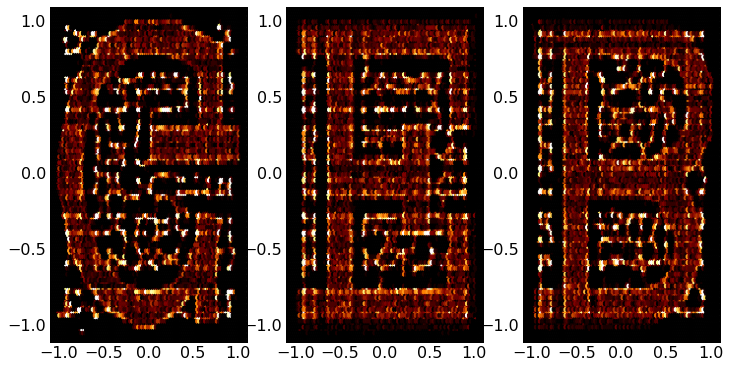

In [45]:
run_training(train_op, 10, plot_frequency=1, rate=0.01)


# TensorFlow Uses All The Cores!

8 cores at 50% is a lot better than 1 core at 100%.

![cpu usage](cpu_usage_geb_1.png)

Would use my GPU too... if I didn't have driver problems

# 10 to 100 iterations

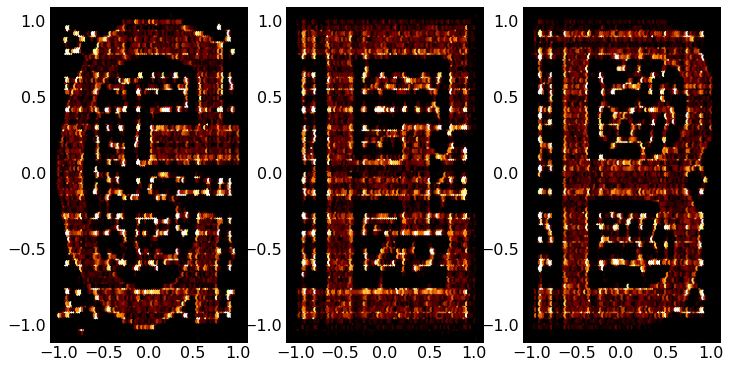

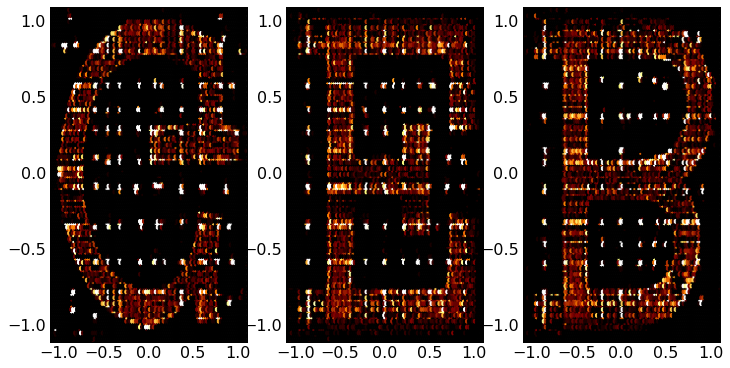

In [46]:
run_training(train_op, 90, plot_frequency=89, rate=0.01)


# 100 to 1000 Iterations

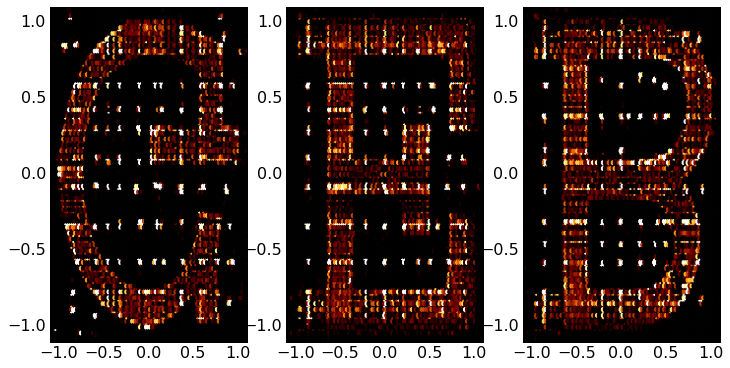

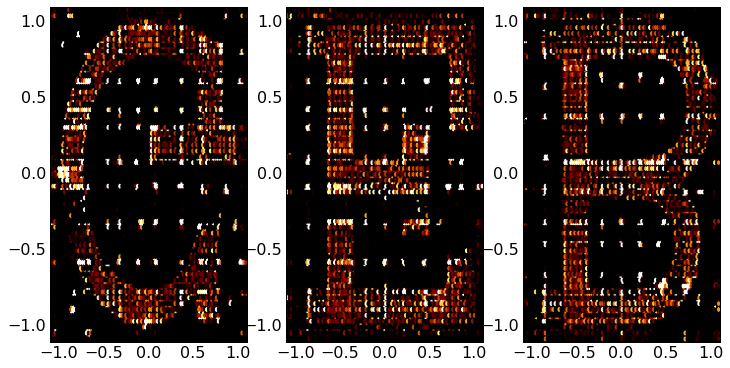

In [47]:
run_training(train_op, 900, plot_frequency=899, rate=0.01)


# Lets Make a Mesh!



In [48]:
cur_cloud = sess.run(cloud)


In [50]:
import pandas as pd
pd.DataFrame({"x":cur_cloud[:, 0], "y":cur_cloud[:, 1], "z":cur_cloud[:, 2]}).to_csv("geb_1.csv")

#python ~/workspace/molten/cloud2mesh.py geb_1.csv --output geb_1.stl
#gmsh geb_1.stl

# Hints of G

![geb_1_xyprofile](../images/geb_1_xyprofile.png)

# Not Quite Perfect

![geb_1_randprofile](../images/geb_1_randprofile.png)

# Print It !

![gside](../images/g_side.jpg)
![eside](../images/e_side.jpg)
![bside](../images/b_side.jpg)



Proof of concept &#10004;

Time for an open source project.

https://www.github.com/quidditymaster/molten

In [61]:
!python ~/workspace/molten/molten.py --help

usage: molten.py [-h] --images [IMAGES [IMAGES ...]] --output OUTPUT [--image-dir IMAGE_DIR]
                 [--invert-images INVERT_IMAGES] [--flip-x FLIP_X] [--flip-y FLIP_Y]
                 [--learning-rate LEARNING_RATE] [--npts NPTS] [--layout LAYOUT]
                 [--rbf-max-radius RBF_MAX_RADIUS] [--rbf-sigma RBF_SIGMA]
                 [--max-image-size MAX_IMAGE_SIZE] [--n-iter N_ITER]
                 [--target-pw-opacity TARGET_PW_OPACITY] [--pw-opacity-sigma PW_OPACITY_SIGMA]
                 [--optimizer OPTIMIZER] [--weight-alpha WEIGHT_ALPHA]
                 [--diagnostic-dir DIAGNOSTIC_DIR]
                 [--diagnostic-frequency DIAGNOSTIC_FREQUENCY] [--hot-start HOT_START]

optional arguments:
  -h, --help            show this help message and exit
  --images [IMAGES [IMAGES ...]]
  --output OUTPUT
  --image-dir IMAGE_DIR
  --invert-images INVERT_IMAGES
  --flip-x FLIP_X
  --flip-y FLIP_Y
  --learning-rate LEARNING_RATE
  --npts NPTS
  --layout LAYOUT
  --rbf-m

# An Physical Model of Common Machine Learning Woes!

In [8]:
%%HTML
<video width="640" height="480" controls>
  <source src="../videos/geb-lrate05.mp4" type="video/mp4">
</video>

* Highly Non-Linear
* Millions of Local Optima
* Vanishing Gradients
* "Dead" parameters
* Imperfect metric

# A Little More Complex



In [9]:
%%HTML
<video width="640" height="480" controls>
  <source src="../videos/logo1.mp4" type="video/mp4">
</video>

# A higher Learning Rate
### ( and better diagnostic plot orientation)

In [10]:
%%HTML
<video width="640" height="480" controls>
  <source src="../videos/logo-lrate05.mp4" type="video/mp4">
</video>

### Tools For Defeating Machine Learning Dragons

* Regularization Losses
* Dropout
* Data Augmentation
* Early Stopping
* Simulated Annealing
* Mini-Batches
* Momentum